# Run a quick layer fidelity experiment on a qubit chain  (default is the most recent 100Q chain from qiskit)

Run layer fidelity on the 100Q chain reported from qiskit and retrieve the experiment analysis. This notebook can easily be adjusted to run layer fidelity on a custom chain.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re
import rustworkx as rx
import pandas as pd
from typing import Dict, List, Tuple
import datetime

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_experiments.framework.experiment_data import ExperimentData
from qiskit_experiments.library.randomized_benchmarking import LayerFidelity
from qiskit.visualization import plot_gate_map
from qiskit.transpiler import CouplingMap

import qiskit_device_benchmarking.utilities.graph_utils as gu
import qiskit_device_benchmarking.utilities.layer_fidelity_utils as lfu

## Get backend

In [4]:
# load service
service = QiskitRuntimeService()

In [21]:
# Specify machine
machine = 'ibm_fez'

# Get backend 
backend = service.backend(machine)

# Get the coupling_map
# coupling_map = CouplingMap(backend.configuration().coupling_map)

## Get most recent 100Q chain from qiskit (or specify a custom chain)

In [6]:
# Get chain from qiskit
qchain = backend.properties().general_qlists[0]['qubits']

# OR specify a custom chain (make sure conncetions exist on the coupling_map) 
# qchain = [0,1,2,3,4,5,6,7]

In [7]:
print('Chain')
print(qchain)

Chain
[31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 77, 85, 86, 87, 97, 107, 108, 109, 110, 111, 112, 113, 119, 133, 132, 131, 130, 129, 128, 127, 137, 147, 146, 145, 144, 143, 136, 123, 122, 121, 116, 101, 102, 103, 96, 83, 82, 81, 76, 61, 62, 63, 56, 43, 44, 45, 37, 25, 24, 23, 16, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 35, 34, 33, 39, 53, 52, 51, 58, 71, 70, 69, 78, 89, 90, 91, 92, 93, 79, 73, 74, 75, 59, 55, 54]


In [9]:
print('Length')
print(len(qchain))

Length
100


## Visualize chain (optional)

Chain for ibm_fez


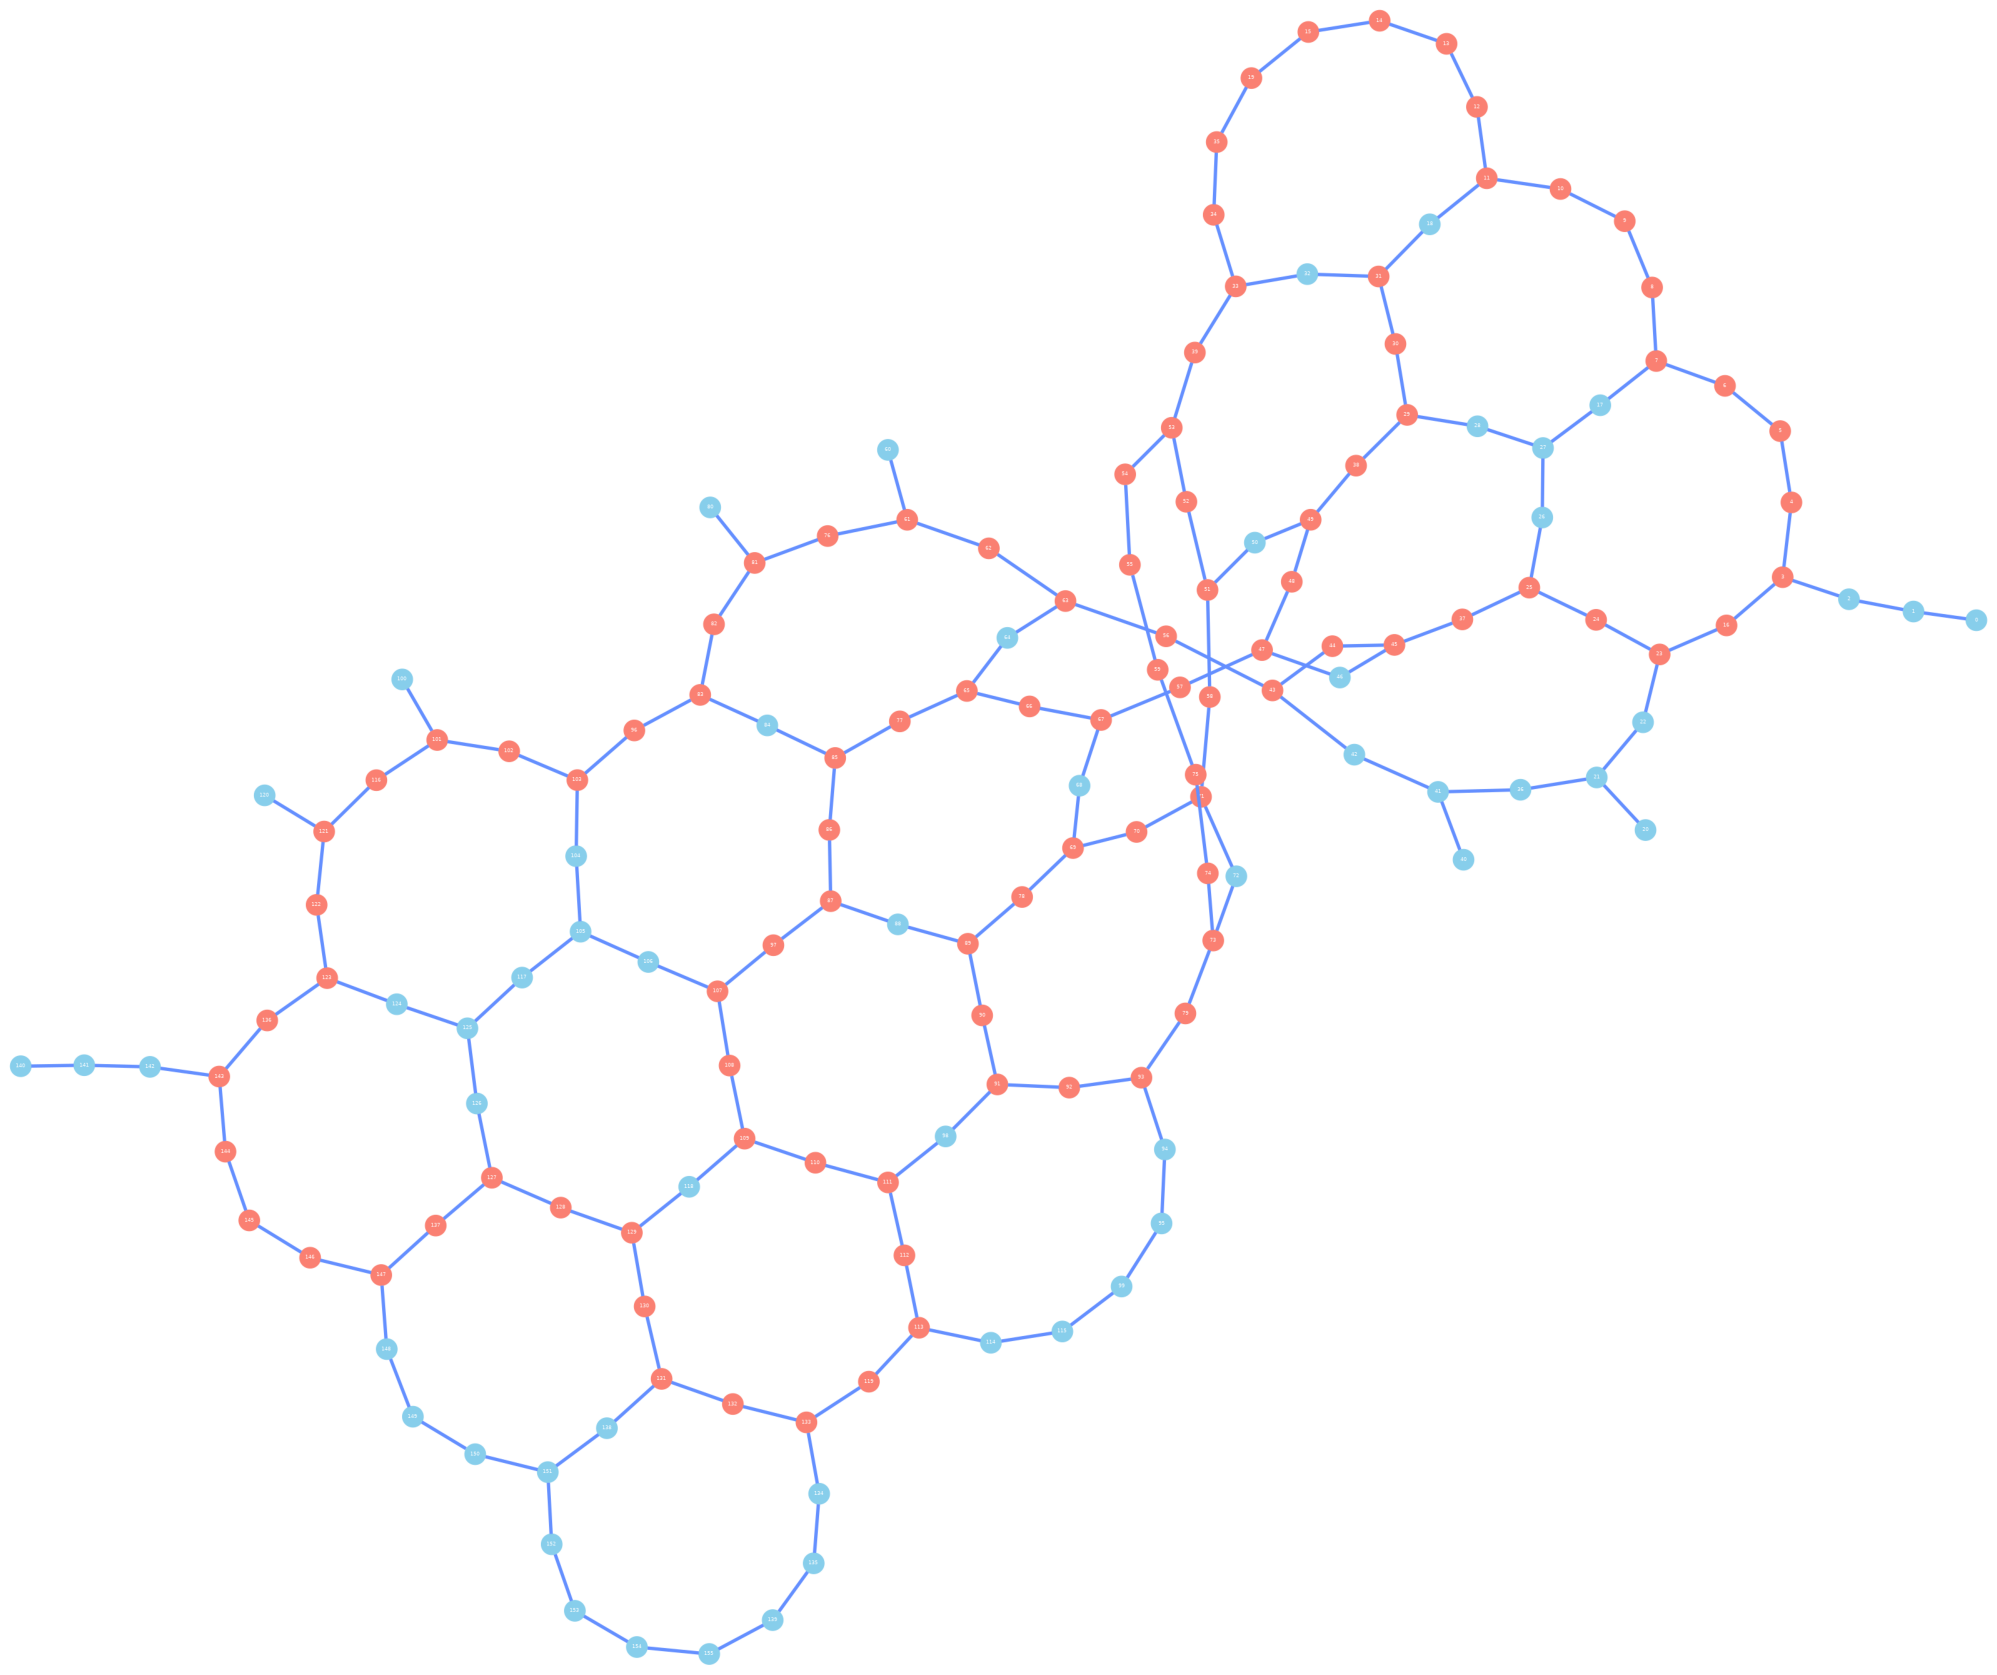

In [10]:
print(f'Chain for {machine}')
qcolors = ['salmon' if i in qchain else 'skyblue' for i in range(0, backend.configuration().n_qubits)]
plot_gate_map(backend, label_qubits=True, qubit_color=qcolors)

## Run layer fidelity on the selected chain

- `physical_qubits`: Physical qubits to use in this benchmarking
- `two_qubit_layers`: List of list of qubit pairs (a list of qubit pairs corresponds with a two-qubit gate layer), qubit direction matters
- `cliff_lengths`: List of layer lengths (the number of depth points)
- `backend`: Backend to be benchmarked
- `nseeds`: How many random circuits should be sampled for each layer length
- `seed`: Seed for the random number generator
- `nshots`: Number of shots

In [14]:
# Define experiment parameters
nseeds = 6
nshots = 200
cliff_lengths = [1, 10, 20, 30, 40, 60, 80, 100, 150, 200, 400]
seed = 42

In [42]:
# Run LF
exp_data = lfu.run_lf_chain(
    chain=qchain,
    backend=backend,
    nseeds=nseeds,
    seed=seed,
    cliff_lengths=cliff_lengths,
    nshots=nshots)

Decomposing qubit chain into two disjoint layers
Disjoint layer 1
[(31, 30), (29, 38), (49, 48), (47, 57), (67, 66), (65, 77), (85, 86), (87, 97), (107, 108), (109, 110), (111, 112), (113, 119), (133, 132), (131, 130), (129, 128), (127, 137), (147, 146), (145, 144), (143, 136), (123, 122), (121, 116), (101, 102), (103, 96), (83, 82), (81, 76), (61, 62), (63, 56), (43, 44), (45, 37), (25, 24), (23, 16), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 19), (35, 34), (33, 39), (53, 52), (51, 58), (71, 70), (69, 78), (89, 90), (91, 92), (93, 79), (73, 74), (75, 59), (55, 54)]
Disjoint layer 2
[(30, 29), (38, 49), (48, 47), (57, 67), (66, 65), (77, 85), (86, 87), (97, 107), (108, 109), (110, 111), (112, 113), (119, 133), (132, 131), (130, 129), (128, 127), (137, 147), (146, 145), (144, 143), (136, 123), (122, 121), (116, 101), (102, 103), (96, 83), (82, 81), (76, 61), (62, 63), (56, 43), (44, 45), (37, 25), (24, 23), (16, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15), (

## Running and retrieving experiment analysis

This runs an experiment analysis and finds the fits. This will take some time depending on the queue of the device.

In [44]:
%%time
# Fit 2Q experiment data
exp_data.block_for_results()

CPU times: user 12.4 s, sys: 10.9 s, total: 23.2 s
Wall time: 2h 25min 37s


ExperimentData(LayerFidelity, 7527cb30-4974-46fe-80fa-048d866383ed, job_ids=['ctgjz9dzhysg008rxrvg'], metadata=<4 items>, figure_names=['DirectRB_Q31_Q30.svg', 'DirectRB_Q29_Q38.svg', 'DirectRB_Q49_Q48.svg', 'DirectRB_Q47_Q57.svg', 'DirectRB_Q67_Q66.svg', 'DirectRB_Q65_Q77.svg', 'DirectRB_Q85_Q86.svg', 'DirectRB_Q87_Q97.svg', 'DirectRB_Q107_Q108.svg', 'DirectRB_Q109_Q110.svg', 'DirectRB_Q111_Q112.svg', 'DirectRB_Q113_Q119.svg', 'DirectRB_Q133_Q132.svg', 'DirectRB_Q131_Q130.svg', 'DirectRB_Q129_Q128.svg', 'DirectRB_Q127_Q137.svg', 'DirectRB_Q147_Q146.svg', 'DirectRB_Q145_Q144.svg', 'DirectRB_Q143_Q136.svg', 'DirectRB_Q123_Q122.svg', 'DirectRB_Q121_Q116.svg', 'DirectRB_Q101_Q102.svg', 'DirectRB_Q103_Q96.svg', 'DirectRB_Q83_Q82.svg', 'DirectRB_Q81_Q76.svg', 'DirectRB_Q61_Q62.svg', 'DirectRB_Q63_Q56.svg', 'DirectRB_Q43_Q44.svg', 'DirectRB_Q45_Q37.svg', 'DirectRB_Q25_Q24.svg', 'DirectRB_Q23_Q16.svg', 'DirectRB_Q3_Q4.svg', 'DirectRB_Q5_Q6.svg', 'DirectRB_Q7_Q8.svg', 'DirectRB_Q9_Q10.svg', 'D

In [45]:
# Get experiment data as DataFrame
df = exp_data.analysis_results(dataframe=True) 

In [46]:
# Get LF result for a length of 100Q
df.loc[df['name']=='LF']

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
047f8552,LF,LayerFidelity,"[Q31, Q30, Q29, Q38, Q49, Q48, Q47, Q57, Q67, ...",0.5765+/-0.0024,bad,ibm_fez,None,None,None,None,None,None,None


In [47]:
# Get EPLG result for a length of 100Q
df.loc[df['name']=='EPLG']

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
3a396d28,EPLG,LayerFidelity,"[Q31, Q30, Q29, Q38, Q49, Q48, Q47, Q57, Q67, ...",0.00555+/-0.00004,bad,ibm_fez,None,None,None,None,None,None,None


## Reconstruct LF and EPLG array per chain length

Construct LF and EPLG arrays ranging in length for the selected 100Q chain. This is different from obtaining the Layer Fidelity and EPLG value in the initial df, as those values only concern a length of 100 qubits (or whatever the length of the qubit chain is).

In [61]:
results_per_length = lfu.reconstruct_lf_per_length(exp_data, qchain, backend)

In [62]:
results_per_length

,qchain_length,qchain,lf,eplg,length,job_ids
0,4,"[137, 147, 146, 145]",[0.9871368212318564],[0.004306243370069129],[4],[ctgjz9dzhysg008rxrvg]
1,5,"[137, 147, 146, 145, 144]","[0.9871368212318564, 0.9836986897986664]","[0.004306243370069129, 0.00410047957493942]","[4, 5]",[ctgjz9dzhysg008rxrvg]
2,6,"[12, 13, 14, 15, 19, 35]","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6]",[ctgjz9dzhysg008rxrvg]
3,7,"[12, 13, 14, 15, 19, 35, 34]","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7]",[ctgjz9dzhysg008rxrvg]
4,8,"[10, 11, 12, 13, 14, 15, 19, 35]","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7, 8]",[ctgjz9dzhysg008rxrvg]
...,...,...,...,...,...,...
92,96,"[31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 7...","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",[ctgjz9dzhysg008rxrvg]
93,97,"[31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 7...","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",[ctgjz9dzhysg008rxrvg]
94,98,"[31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 7...","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",[ctgjz9dzhysg008rxrvg]
95,99,"[31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 7...","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",[ctgjz9dzhysg008rxrvg]


In [50]:
# Get the best subchain of a specific length
l = 60
results_per_length[results_per_length['qchain_length']==l]

,qchain_length,qchain,lf,eplg,length,job_ids
56,60,"[131, 130, 129, 128, 127, 137, 147, 146, 145, ...","[0.9871368212318564, 0.9836986897986664, 0.979...","[0.004306243370069129, 0.00410047957493942, 0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",[ctgjz9dzhysg008rxrvg]


In [51]:
# save lf and eplg data per chain length
# results_per_length.to_csv(f'{machine}_lf_eplg_data.csv', float_format='%.15f')

## Plot LF and EPLG per chain length

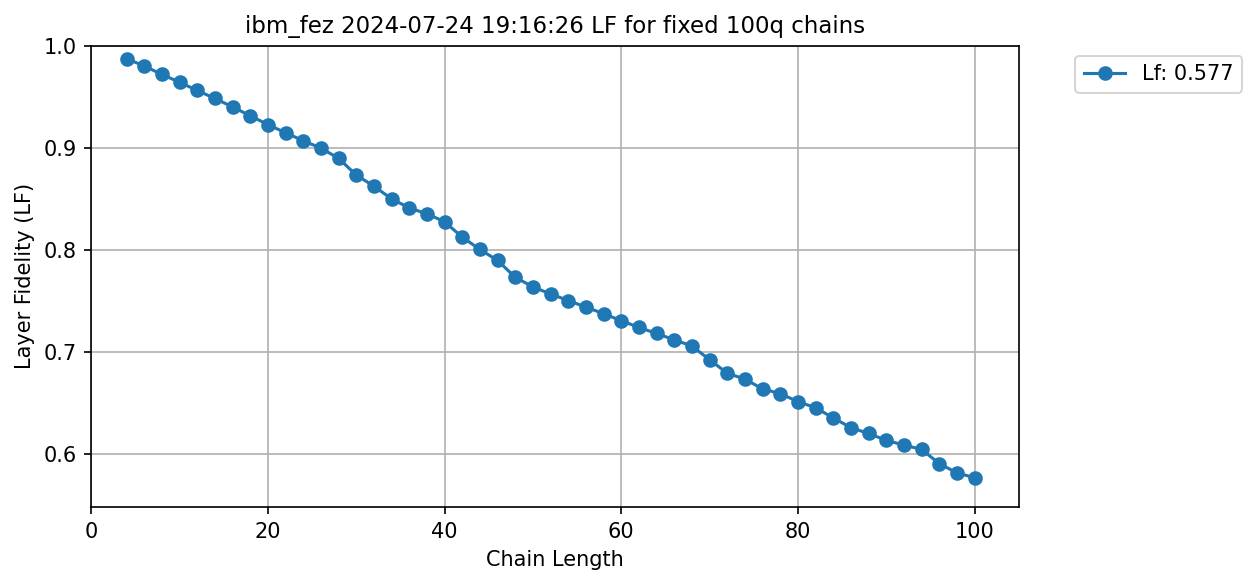

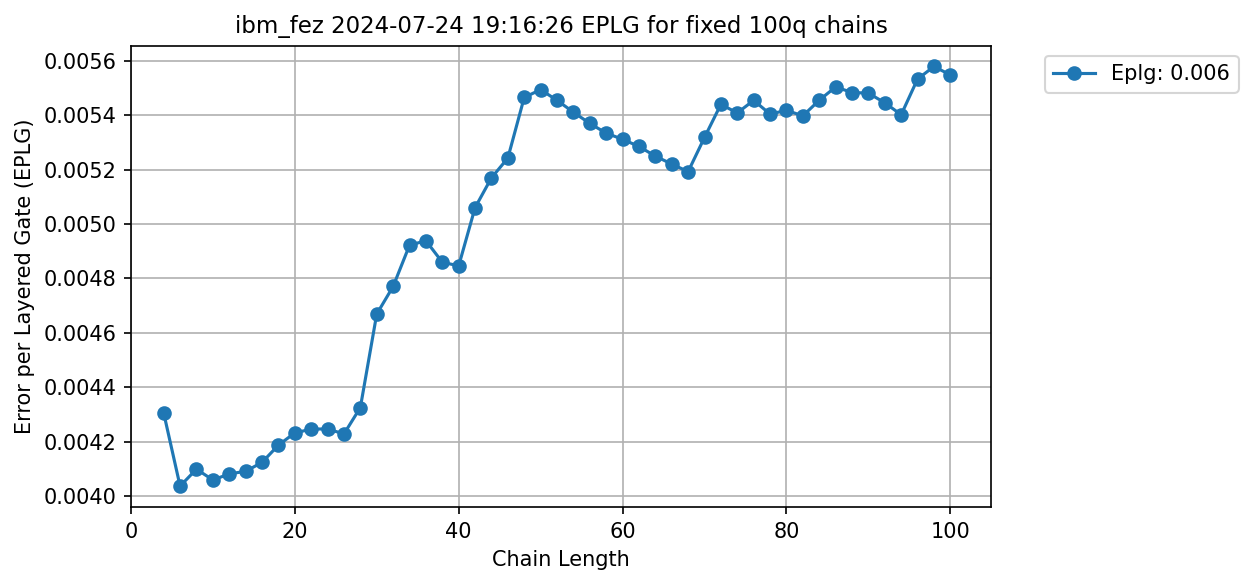

In [52]:
lfu.make_lf_eplg_plots(
    exp_data=exp_data,
    chain=qchain,
    machine=machine
)

## Retrieve raw and fitted RB data (optional)

In [53]:
# Retrieve raw and fitted RB data (if people are interested, not necessary for this notebook)
rb_data_df = lfu.get_rb_data(exp_data)
rb_data_df

,xval,yval,yerr,series_name,series_id,category,shots,analysis,qubits
0,1.0,0.977612,0.010409,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(31, 30)"
1,10.0,0.90796,0.02034,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(31, 30)"
2,20.0,0.91791,0.019314,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(31, 30)"
3,30.0,0.843284,0.025578,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(31, 30)"
4,40.0,0.833333,0.026222,rb_decay,0,raw,200,_ProcessFidelityAnalysis,"(31, 30)"
...,...,...,...,...,...,...,...,...,...
17872,383.878788,0.612071,0.010518,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(54,)"
17873,387.909091,0.609428,0.010754,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(54,)"
17874,391.939394,0.606797,0.010996,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(54,)"
17875,395.969697,0.604178,0.011246,rb_decay,0,fitted,<NA>,_ProcessFidelityAnalysis,"(54,)"


In [54]:
# Save RB data locally
# rb_data_df.to_csv('full_rb_data.csv', float_format='%.15f')

## Plotting RB results (optional)

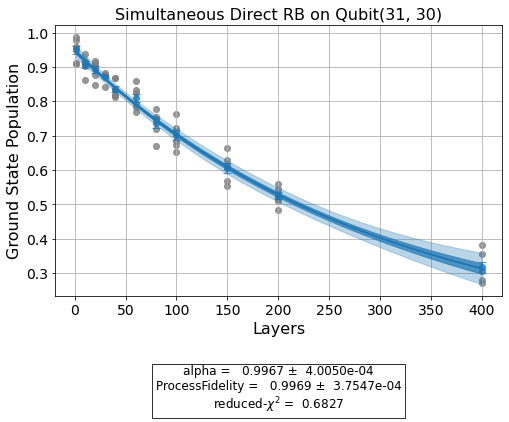

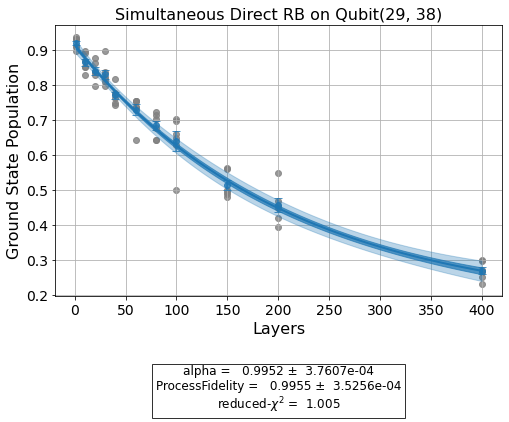

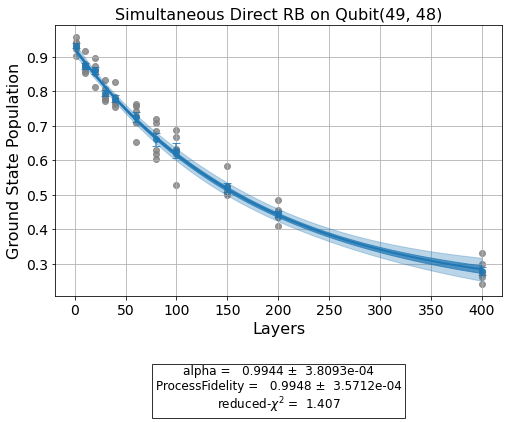

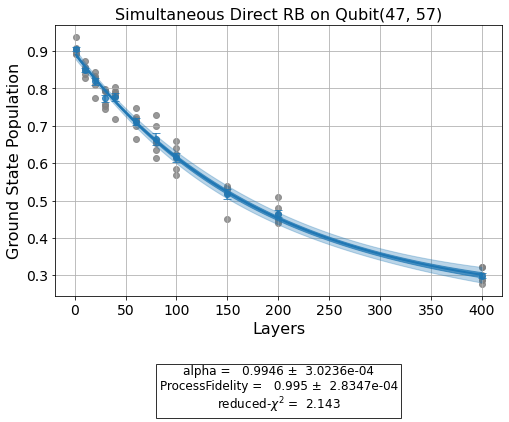

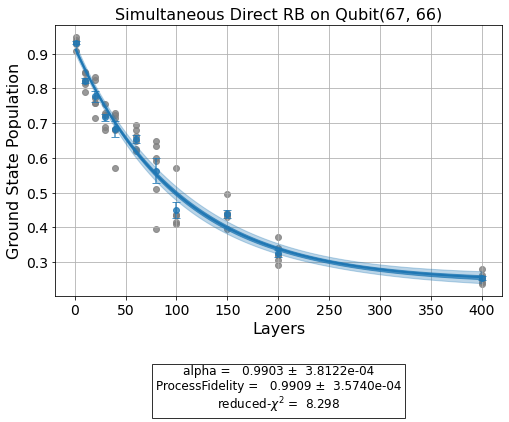

In [55]:
# Plot 1Q/2Q simultaneous direct RB curves
for i in range(5):
    display(exp_data.figure(i))

## Quick look at circuits (optional)

This cell can be skipped. The function `run_lf_chain()` will run LF on the selected chain without the need to run this cell.

CPU times: user 16.5 s, sys: 94.5 ms, total: 16.6 s
Wall time: 16.7 s


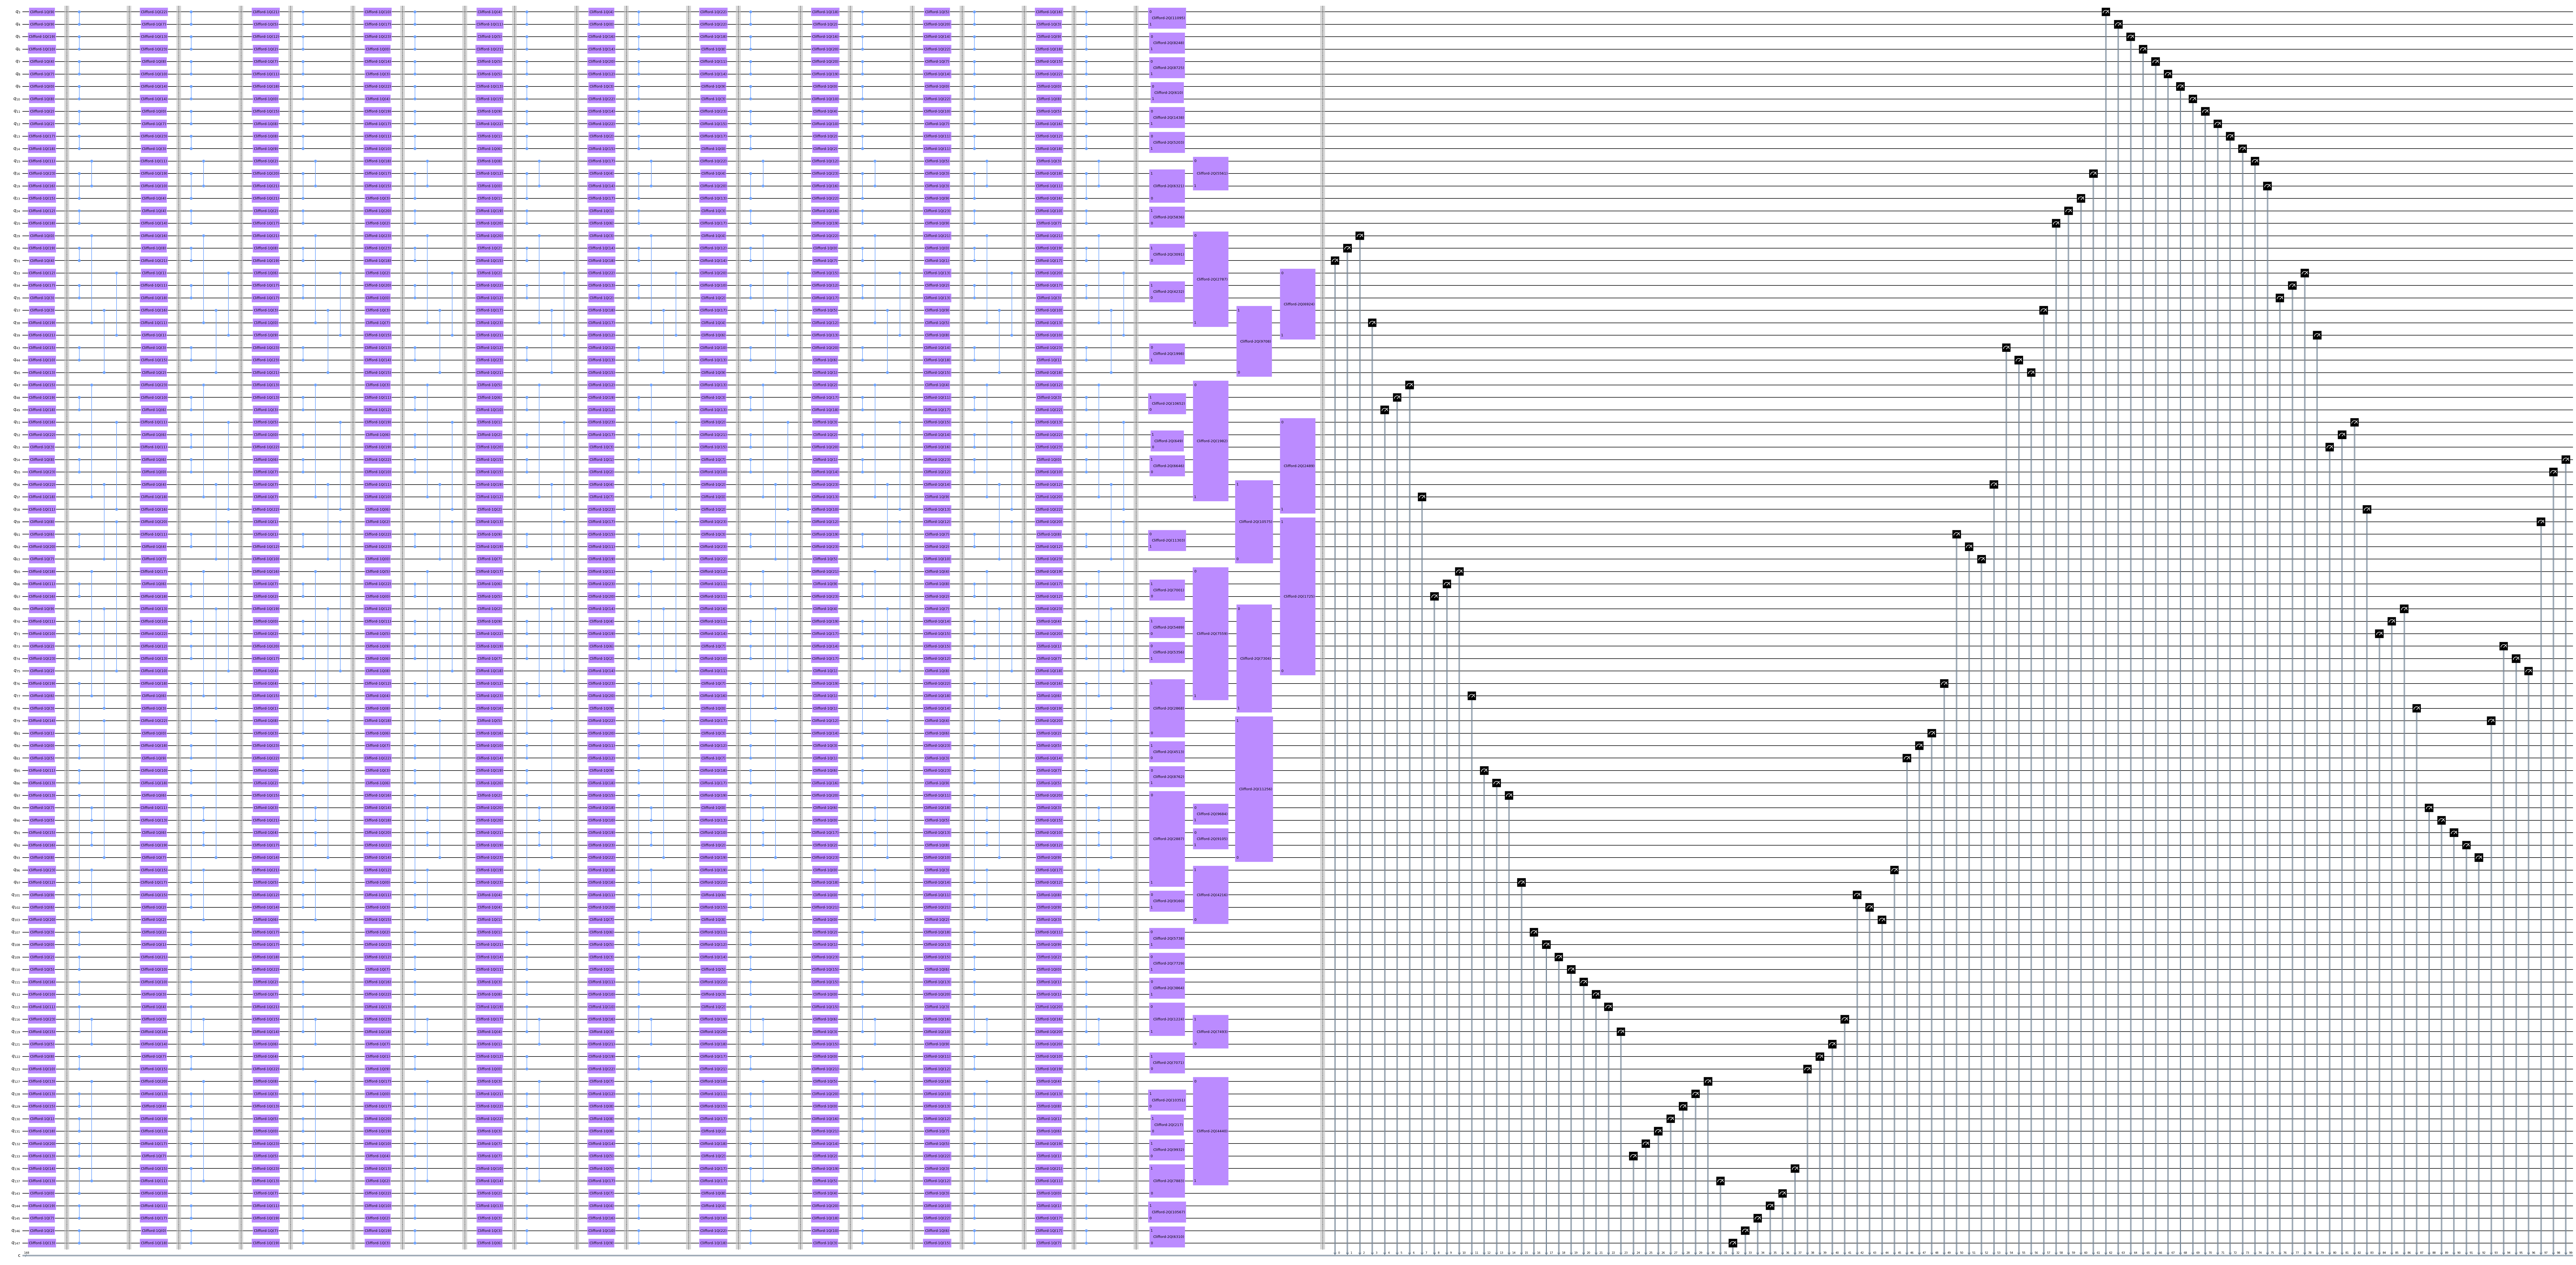

In [56]:
%%time
# Get two qubit gate
if "ecr" in backend.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend.configuration().basis_gates:
    twoq_gate = "cz"
else:
    twoq_gate = 'cx'
    
# Get one qubit basis gates
oneq_gates = []
for i in backend.configuration().basis_gates:
    if i.casefold()!=twoq_gate.casefold():
            oneq_gates.append(i)
            
# Get the coupling_map
coupling_map = CouplingMap(backend.configuration().coupling_map)

# Get graph from coupling map
G = coupling_map.graph

# Decompose chain into trivial two disjoint layers (list of list of gates)
all_pairs = path_to_edges([qchain], coupling_map)[0]
layers = [all_pairs[0::2], all_pairs[1::2]] # will run a layer for each list

# Create Layer Fidelity Instance
lfexp = LayerFidelity(
        physical_qubits=qchain,
        two_qubit_layers=layers,
        lengths=cliff_lengths,
        backend=backend,
        num_samples=nseeds,
        seed=seed,
        two_qubit_gate=twoq_gate,
        one_qubit_basis_gates=oneq_gates,
    )
lfexp.set_experiment_options(max_circuits=2 * nseeds * len(cliff_lengths))
    
# look at one of the first three 2Q direct RB circuits quickly
circ_iter = lfexp.circuits_generator()
first_three_circuits = list(next(circ_iter) for _ in range(3))
first_three_circuits[1].draw(output="mpl", style="clifford", idle_wires=False, fold=-1)

## Filter qubit pairs with bad process fidelity (optional)

In [57]:
# Select table with process fidelities
pfdf = df[(df.name == "ProcessFidelity")]

# Find bad quality analysis results
pfdf[pfdf.quality == "bad"]

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
160068ef,ProcessFidelity,LayerFidelity,"[Q67, Q66]",0.9909+/-0.0004,bad,ibm_fez,None,"(67, 66)",large_chisq,0.674913,0.99029,0.242662,8.298233
956018d0,ProcessFidelity,LayerFidelity,"[Q109, Q110]",0.9959+/-0.0004,bad,ibm_fez,None,"(109, 110)",large_chisq,0.811744,0.995642,0.140715,3.729779
f1dc8e11,ProcessFidelity,LayerFidelity,"[Q145, Q144]",0.99763+/-0.00026,bad,ibm_fez,None,"(145, 144)",large_chisq,0.914468,0.997468,0.0,4.660294
7292de31,ProcessFidelity,LayerFidelity,"[Q83, Q82]",0.9944+/-0.0005,bad,ibm_fez,None,"(83, 82)",large_chisq,0.664335,0.993993,0.194275,5.218799
c4dc63d6,ProcessFidelity,LayerFidelity,"[Q81, Q76]",0.9880+/-0.0006,bad,ibm_fez,None,"(81, 76)",large_chisq,0.610542,0.987187,0.272539,4.220741
e25175f6,ProcessFidelity,LayerFidelity,"[Q45, Q37]",0.99598+/-0.00024,bad,ibm_fez,None,"(45, 37)",large_chisq,0.620505,0.995711,0.334936,3.489814
95620cc2,ProcessFidelity,LayerFidelity,"[Q93, Q79]",0.9973+/-0.0005,bad,ibm_fez,None,"(93, 79)",large_chisq,0.722374,0.997158,0.009084,8.445874
0524710b,ProcessFidelity,LayerFidelity,"[Q75, Q59]",0.99452+/-0.00029,bad,ibm_fez,None,"(75, 59)",large_chisq,0.746039,0.99415,0.1974,3.001524
c5584954,ProcessFidelity,LayerFidelity,"[Q132, Q131]",0.99763+/-0.00028,bad,ibm_fez,None,"(132, 131)",large_chisq,0.949252,0.997474,0.0,4.146914
794e7e11,ProcessFidelity,LayerFidelity,"[Q146, Q145]",0.9962+/-0.0004,bad,ibm_fez,None,"(146, 145)",large_chisq,0.72186,0.995926,0.194691,3.207347
